# Physical Properties of Synestias

You'll notice that synestias are very large planetary objects. They span about 200,000 km across (124,000 miles) -- that's almost 16 Earths! This synestia was formed as a result of a potential-Moon-forming giant impact. A giant impact is a collision between massive planetary objects. Giant impacts deposit enough energy into the impacted material to vaporize rock (about the total daily energy output from the Sun). Synestias have a large (10-20% of total mass) vapor component which makes them very hot, extended and puffy.

What does "very hot" mean?

Note: Physicists like to tackle complicated problems by breaking down and simplifying the problem. Typically, an intricate, connected body is broken down into smaller pieces (<i>discretization</i>). We cannot model continuous fluids (which is what a synestia is in reality), so we break them up into a collection of smaller, discrete components. You can think of an ocean as a collection of drops. Modeling the forces on each drop and analyzing the collective result of the drops is much easier than trying to describe the complex behavior of an entire ocean. This is true here as well. When synestias are modeled, their continuous fluid bodies are simulated using a system of particles. Think of these particles as having volume -- like a parcel of gas. It's easier to get a sense of the whole structure when looking at how the individual parcels behave. The plots below use data output from giant impact simulations, which model continuous fluids in synestias using particles (variously sized gas volumes) to approximate reality.

## Temperature Profile of a Synestia

In [2]:
from syndef import synfits
import numpy as np
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
from ipywidgets import interact,FloatSlider,fixed

#define gridded arrays where want x,y,z points on plots
n = 256 #number of gridded points for xyz arrays
x_absmax = 30e6 #m
z_absmax = 20e6 #m

#assign particle information to single variable & convert units
T_unfilt=synfits.SNAP_CukStewart.T #K
x_unfilt=synfits.SNAP_CukStewart.x/1e3 #km
y_unfilt=synfits.SNAP_CukStewart.y/1e3 #km
z_unfilt=synfits.SNAP_CukStewart.z/1e3 #km
S_unfilt=synfits.SNAP_CukStewart.S #J/K/kg
filt=~((np.abs(z_unfilt)>30000*(T_unfilt-5000)**(-1/12))&(T_unfilt>5000.))
T=T_unfilt[filt]
x=x_unfilt[filt]
y=y_unfilt[filt]
z=z_unfilt[filt]
S=S_unfilt[filt]

#sort data into kdtree
xyz = np.vstack((x,y,z)).transpose() #km
tree = cKDTree(xyz) #make tree, sort particles into leafs

#create x,y,z arrays and turn them into 2-D arrays
xarr = np.linspace(-x_absmax,x_absmax,n)/1e3 #km
zarr = np.linspace(-z_absmax,z_absmax,n)/1e3 #km
Xarr,Zarr = np.meshgrid(xarr,zarr) #km, km
yarr = np.linspace(-x_absmax,x_absmax,n)/1e3 #km
Xarr2,Yarr = np.meshgrid(xarr,yarr) #km, km

#function that gets nearest neighbor information for gridded points
#and plots their physical property value using pcolormesh
def temperature_xz(yvalue,Xarr,Zarr,T):
    Yarr = np.ones_like(Xarr)*yvalue #km
    XYZ = np.vstack((Xarr.flatten(),Yarr.flatten(),Zarr.flatten())).transpose() #km
    d,ind = tree.query(XYZ) #find nearest neighbor to use for temperature at X,Y,Z points
    temp = T[ind].reshape(Xarr.shape)
    #dtest,indtest = tree.query(XYZ,k=3) #find nearest 3 neighbors
    #temp_k = (((18./11.)*T[indtest[:,0]] + (9./11.)*T[indtest[:,1]] + (6./11.)*T[indtest[:,2]])/3).reshape(Xarr.shape) #weighted mean

    plt.figure(figsize=(6,3.25))
    plt.title('Temperature Profile: Side View')
    plt.xlabel('x (km)')
    plt.ylabel('z (km)')
    plt.axis('equal')
    plt.pcolormesh(Xarr,Zarr,temp,vmin=np.amin(T),vmax=15000)
    #plt.pcolormesh(Xarr,Zarr,temp_k,vmin=np.amin(T),vmax=15000)
    plt.colorbar(label='temperature (K)')
    plt.show()
    plt.close()
    
def temperature_xy(zvalue,Xarr,Yarr,T):
    Zarr = np.ones_like(Xarr)*zvalue #km
    XYZ = np.vstack((Xarr.flatten(),Yarr.flatten(),Zarr.flatten())).transpose() #km
    d,ind = tree.query(XYZ) #find nearest neighbor to use for temperature at X,Y,Z points
    #dtest,indtest = tree.query(XYZ,k=3) #find nearest 3 neighbors
    #temp_k = ((T[indtest[:,0]] + 0.5*T[indtest[:,1]] + (1./3.)*T[indtest[:,2]])/3).reshape(Xarr.shape) #weighted mean
    temp = T[ind].reshape(Xarr.shape)

    plt.figure(figsize=(6,5))
    plt.title('Temperature Profile: Bird\'s Eye View')
    plt.xlabel('x (km)')
    plt.ylabel('y (km)')
    plt.axis('equal')
    plt.pcolormesh(Xarr,Yarr,temp,vmin=np.amin(T),vmax=15000)
    plt.colorbar(label='temperature (K)')
    plt.show()
    plt.close()

style = {'description_width': 'initial'}
layout = {'width': '400px'}
interact(temperature_xz,yvalue = FloatSlider(value=0, min=-30e3, max=30e3, step=2e3, description='Depth into Planet (km)',
                      continuous_update=True, readout=True, readout_format='.1e', style=style, layout=layout),
         Xarr=fixed(Xarr), Zarr=fixed(Zarr), T=fixed(T)
        )
interact(temperature_xy,zvalue = FloatSlider(value=0, min=-20e3, max=20e3, step=2e3, description='Distance from Midplane (km)',
                      continuous_update=True, readout=True, readout_format='.1e', style=style, layout=layout),
         Xarr=fixed(Xarr2), Yarr=fixed(Yarr), T=fixed(T)
        )

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in power
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in greater


interactive(children=(FloatSlider(value=0.0, description='Depth into Planet (km)', layout=Layout(width='400px'…

interactive(children=(FloatSlider(value=0.0, description='Distance from Midplane (km)', layout=Layout(width='4…

<function __main__.temperature_xy(zvalue, Xarr, Yarr, T)>

Pretty darn hot! If teleportation is ever discovered, don't ask to be sent into a synestia. Imagine a volcanic eruption, but 2 to 15 times hotter.

## Pressure Profile of a Synestia

There is no solid surface upon which we could stand, but if we somehow were floating in the moon-forming region of a synestia, it would feel like a (burning) hot, heavy atmospheric blanket.
Our atmosphere is 1 atm, so imagine how it would feel to have the weight of 10's or 100's of Earth's atmosphere surrounding you! That is what the pressure of a synestia's gas would feel like. In the interior of a synestia, there is a hot outer core with a hot atmosphere surrounding it.

In [3]:
#do same thing for pressure
P=synfits.SNAP_CukStewart.P #Pa

def pressure_xz(yvalue,Xarr,Zarr,P):
#yvalue,Xarr,Zarr are in km; P is in Pa
    Yarr = np.ones_like(Xarr)*yvalue #km
    XYZ = np.vstack((Xarr.flatten(),Yarr.flatten(),Zarr.flatten())).transpose() #km
    d,ind = tree.query(XYZ) #find nearest neighbor to use for temperature at X,Y,Z points
    #dtest,indtest = tree.query(XYZ,k=3) #find nearest 3 neighbors
    #temp_k = ((T[indtest[:,0]] + 0.5*T[indtest[:,1]] + (1./3.)*T[indtest[:,2]])/3).reshape(Xarr.shape) #weighted mean
    press = np.log10(P[ind].reshape(Xarr.shape)/101325.) #atm

    plt.figure(figsize=(6,3.25))
    plt.title('Pressure Profile: Side View')
    plt.xlabel('x (km)')
    plt.ylabel('z (km)')
    plt.axis('equal')
    plt.pcolormesh(Xarr,Zarr,press,vmin=np.amin(np.log10(P/101325.)),vmax=np.amax(np.log10(P/101325.)))
    plt.colorbar(label='log$_{10}$(pressure) (atm)')
    plt.show()
    plt.close()

def pressure_xy(zvalue,Xarr,Yarr,P):
#zvalue,Xarr,Yarr are in km; P is in Pa
    Zarr = np.ones_like(Xarr)*zvalue #km
    XYZ = np.vstack((Xarr.flatten(),Yarr.flatten(),Zarr.flatten())).transpose() #km
    d,ind = tree.query(XYZ) #find nearest neighbor to use for temperature at X,Y,Z points
    #dtest,indtest = tree.query(XYZ,k=3) #find nearest 3 neighbors
    #temp_k = ((T[indtest[:,0]] + 0.5*T[indtest[:,1]] + (1./3.)*T[indtest[:,2]])/3).reshape(Xarr.shape) #weighted mean
    press = np.log10(P[ind].reshape(Xarr.shape)/101325.) #atm

    plt.figure(figsize=(6,5))
    plt.title('Pressure Profile: Bird\'s Eye View')
    plt.xlabel('x (km)')
    plt.ylabel('y (km)')
    plt.axis('equal')
    plt.pcolormesh(Xarr,Yarr,press,vmin=np.amin(np.log10(P/101325.)),vmax=np.amax(np.log10(P/101325.)))
    plt.colorbar(label='log$_{10}$(pressure) (atm)')
    plt.show()
    plt.close()

interact(pressure_xz,yvalue = FloatSlider(value=0, min=-30e3, max=30e3, step=2e3, description='Depth into Planet (km)',
                      continuous_update=True, readout=True, readout_format='.1e', style=style, layout=layout),
         Xarr=fixed(Xarr), Zarr=fixed(Zarr), P=fixed(P)
        )
interact(pressure_xy,zvalue = FloatSlider(value=0, min=-20e3, max=20e3, step=2e3, description='Distance from Midplane (km)',
                      continuous_update=True, readout=True, readout_format='.1e', style=style, layout=layout),
         Xarr=fixed(Xarr2), Yarr=fixed(Yarr), P=fixed(P)
        )

interactive(children=(FloatSlider(value=0.0, description='Depth into Planet (km)', layout=Layout(width='400px'…

interactive(children=(FloatSlider(value=0.0, description='Distance from Midplane (km)', layout=Layout(width='4…

<function __main__.pressure_xy(zvalue, Xarr, Yarr, P)>

If you have ever been swimming, the pressure you feel (most noticeably in your ears) at a depth of 10 meters (33 feet) of water is 2 atm. The pressure felt by a synestia's vapor in its moon-forming region (100 atm in this case) will be at least five times that. That's a tremendous amount of pressure! It's the reason why a synestia's gas has such an effect on the dynamics within a synestia. The pressure is an additional significant force that allows the synestia to be very puffy and large and emplaces more moon-forming material in the moon-forming region than a traditional moon-forming disk could. High pressures also contribute to chemical equilibrium of material (making rocky material in a synestia as "homogeneous" as possible) and the gaseous and vaporous thermal regime of the rocky material in a synestia.

## Density Profile of a Synestia

Now that you have an idea of how heavy a synestia's gas would feel, how thick would the gas be? In order words, how dense would it be? For example, in our own atmosphere, we experience fog, which is much more dense with water than we typically experience in our air. For comparison, our air's density is 1.225 kg/m$^3$ [under standard conditions (at sea level and 15&deg;C); International Standard Atmosphere] and liquid water on Earth has a density of about 1000 kg/m$^3$.

In [3]:
#do same thing for density
rho=synfits.SNAP_CukStewart.rho #kg/m^3

def density_xz(yvalue,Xarr,Zarr,rho):
#yvalue,Xarr,Zarr are in km; rho is in kg/m^3
    Yarr = np.ones_like(Xarr)*yvalue #km
    XYZ = np.vstack((Xarr.flatten(),Yarr.flatten(),Zarr.flatten())).transpose() #km
    d,ind = tree.query(XYZ) #find nearest neighbor to use for temperature at X,Y,Z points
    #dtest,indtest = tree.query(XYZ,k=3) #find nearest 3 neighbors
    #temp_k = ((T[indtest[:,0]] + 0.5*T[indtest[:,1]] + (1./3.)*T[indtest[:,2]])/3).reshape(Xarr.shape) #weighted mean
    dens = np.log10(rho[ind].reshape(Xarr.shape)) #kg/m^3

    plt.figure(figsize=(6,3.25))
    plt.title('Density Profile: Side View')
    plt.xlabel('x (km)')
    plt.ylabel('z (km)')
    plt.axis('equal')
    plt.pcolormesh(Xarr,Zarr,dens,vmin=np.amin(np.log10(rho)),vmax=np.amax(np.log10(rho)))
    plt.colorbar(label='log$_{10}$(density) (kg/m$^3$)')
    plt.show()
    plt.close()

def density_xy(zvalue,Xarr,Yarr,rho):
#zvalue,Xarr,Yarr are in km; rho is in kg/m^3
    Zarr = np.ones_like(Xarr)*zvalue #km
    XYZ = np.vstack((Xarr.flatten(),Yarr.flatten(),Zarr.flatten())).transpose() #km
    d,ind = tree.query(XYZ) #find nearest neighbor to use for temperature at X,Y,Z points
    #dtest,indtest = tree.query(XYZ,k=3) #find nearest 3 neighbors
    #temp_k = ((T[indtest[:,0]] + 0.5*T[indtest[:,1]] + (1./3.)*T[indtest[:,2]])/3).reshape(Xarr.shape) #weighted mean
    dens = np.log10(rho[ind].reshape(Xarr.shape)) #kg/m^3

    plt.figure(figsize=(6,5))
    plt.title('Density Profile: Bird\'s Eye View')
    plt.xlabel('x (km)')
    plt.ylabel('y (km)')
    plt.axis('equal')
    plt.pcolormesh(Xarr,Yarr,dens,vmin=np.amin(np.log10(rho)),vmax=np.amax(np.log10(rho)))
    plt.colorbar(label='log$_{10}$(density) (kg/m$^3$)')
    plt.show()
    plt.close()

interact(density_xz,yvalue = FloatSlider(value=0, min=-30e3, max=30e3, step=2e3, description='Depth into Planet (km)',
                      continuous_update=True, readout=True, readout_format='.1e', style=style, layout=layout),
         Xarr=fixed(Xarr), Zarr=fixed(Zarr), rho=fixed(rho)
        )
interact(density_xy,zvalue = FloatSlider(value=0, min=-20e3, max=20e3, step=2e3, description='Distance from Midplane (km)',
                      continuous_update=True, readout=True, readout_format='.1e', style=style, layout=layout),
         Xarr=fixed(Xarr2), Yarr=fixed(Yarr), rho=fixed(rho)
        )

interactive(children=(FloatSlider(value=0.0, description='Depth into Planet (km)', layout=Layout(width='400px'…

interactive(children=(FloatSlider(value=0.0, description='Distance from Midplane (km)', layout=Layout(width='4…

<function __main__.density_xy(zvalue, Xarr, Yarr, rho)>

A synestia can be either very dense or hardly dense at all (less dense than our air); it depends largely on the region we investigate. The vapor at the farthest radii will be less dense, while the center and vapor along the midplane will be the most dense (#-# times as dense as _).

Part of this has to with the temperature and pressure regime a particular region is in; part of it has to do with the mass distribution within a synestia. Let's take a look at the gravity field to get a better sense of the mass distribution within a synestia.

## Gravity Field of a Synestia

A gravity field represents the spatial distribution of mass within a body. Physicists and geologists think about the total gravity of a body as the sum of the body's individual parts and contributions to its total gravity field. So, if we were to break up Earth into lots of chunks, these chunks each have an individual mass and position relative to the center of the body. The more mass and closer to the center a chunk is, the stronger effect it will have gravitationally on the gravity field, which emananates from the center of the body.

If we apply this thought process to a synestia, then we can represent a synestia, a continuous body of fluid (gas in particular), as a cloud of gas particles, where each particle has its own mass, size, position, and velocity. In fact, this is how synestias are modeled (because fluid dynamics are complicated and this is the easiest way to approximate the physics of fluids). Let's take a look below.

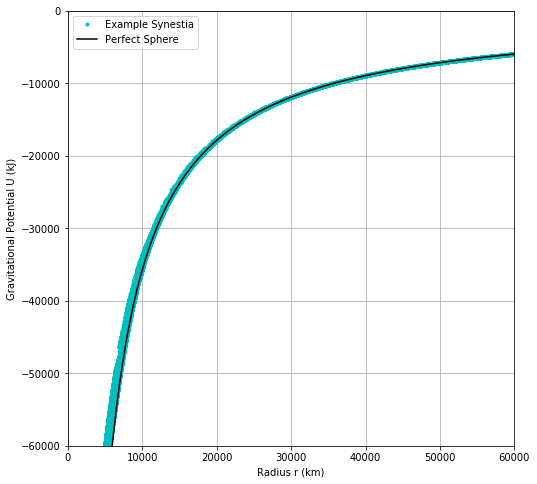

In [4]:
G = 6.67408e-11 #mks
M_Earth = np.sum(synfits.SNAP_Canup.m) #kg
U_syn = synfits.SNAP_Canup.pot/1e3
r_syn = np.sqrt(synfits.SNAP_Canup.x**2 + synfits.SNAP_Canup.y**2 + synfits.SNAP_Canup.z**2)
r_sphere = np.linspace(1.e6,3.5e8,1000)
U_sphere = -G*M_Earth/(r_sphere*1e3)
U_diff = -G*M_Earth/(r_syn*1e3) - U_syn

plt.figure(figsize=(8,8))
plt.plot(r_syn/1e3,U_syn,'c.',label='Example Synestia')
plt.plot(r_sphere/1e3,U_sphere,'k',label='Perfect Sphere')
plt.xlabel('Radius r (km)')
plt.ylabel('Gravitational Potential U (kJ)')
plt.ylim([-6e4,0])
plt.xlim([0,6e4])
plt.legend(loc=2)
plt.grid()
plt.show()
plt.close()

You'll notice that the gravitational potential field of a synestia is a bit different from that a sphere (which we are used to since present-day Earth is nearly spherical). In the disk-like region (radius r > 10,000 km), gravitational potential energy is greater (more negative) at larger radii (r > 30,000 km) for a perfect sphere than it is for a synestia. Also, gravitational potential energy is weaker (less negative) at smaller radii (10,000 km > r > 30,000 km) for a perfect sphere than it is for a synestia. Since synestias are oblate with a central mass extending to large radii (about 10,000 km), then it makes sense that gravitational potential energy is significant in the inner part of the disk-like region in a synestia.

For a synestia, gravitational acceleration is much stronger along the midplane than it is off the midplane. The extra gravitational pull arises from the oblate structure of a synestia. A synestia is very flared and has a disk-like shape away from its center. Its interior is spinning very rapidly, causing mass along the midplane to bulge out. The contribution this bulge, or oblateness, has on the gravitational field is what is called the second-order gravity term, or J$_2$ term.

The first-order term (1/r) of the gravitational acceleration that a particular body exerts on other objects is largely affected by the radius (how far its mass extends out from its center) of that body. However, the second-order term (1/r$^3$) is largely affected by the mass distribution within that body, namely, along the midplane (z = 0, i.e. equator if you're thinking about Earth). Let's take a look below at the equation for the gravitational potential U. The J$_2$ term will be strongest near the midplane and at cylindrical radii where r$_{xy}/z > \sqrt{2}$.

$$U = -\frac{GM}{r}(1 - \frac{J_2a_{eq}^2}{2r^2}(\frac{3z^2}{r^2} - 1)$$

G is the gravitational constant, M is the total mass of the body, r(x,y,z) is the position of a particle in 3-D space, a$_{eq}$ is the equatorial radius of the body, and J$_2$ is a unitless number from 0 to 1 that depends on how spherical the mass distribution is. The more spherical the body is, the smaller J$_2$ will be. If the body is more squashed, bulging, or oblate, J$_2$ will be larger. For reference, Earth is nearly spherical with a J$_2$ of 0.001083; Earth's equatorial radius is ever so slightly larger than its polar radius due to its rotation.

However, changing the mass distribution within a body will also affect J$_2$. It is possible to have two bodies with the same oblateness, but different J$_2$ values. Say there is one body of uniform density and the other body is split into a denser central region (like a core) and a less dense outer region (like a mantle). The uniform density spheroid will have a larger J$_2$ than the body with a varying density distribution (more mass concentrated near the center of the body). See the figure (11.2 from http://web.gps.caltech.edu/classes/ge131/notes2016/Ch11.pdf) below.

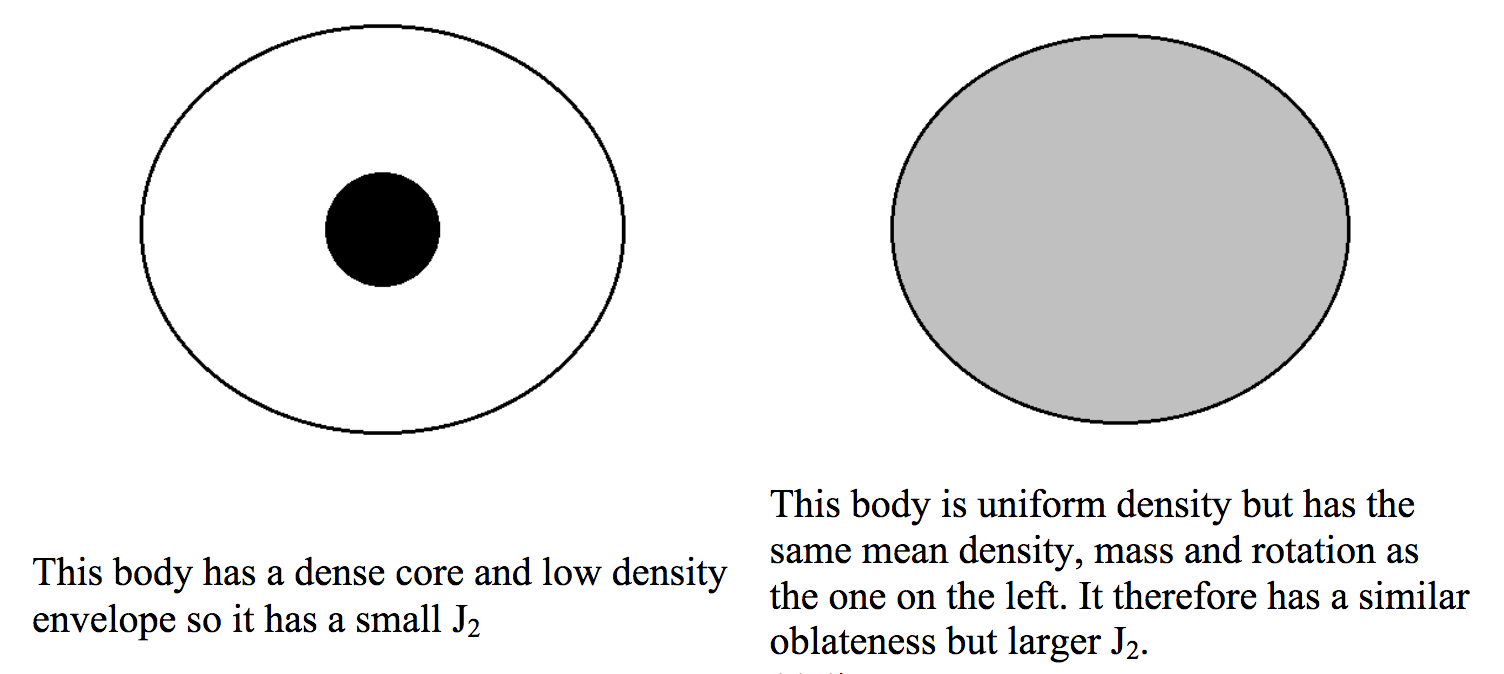